In [69]:
from bertopic import BERTopic
import pandas as pd
import numpy as np
from transformers.pipelines import pipeline
import matplotlib.pyplot as plt
from bertopic.representation import TextGeneration
from tqdm import tqdm
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from umap import UMAP
from unidecode import unidecode
import re
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to /home/jstet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [70]:
df = pd.read_csv("./data/sample.csv")

In [71]:
# calculate mean length of text in words
df["length"] = df["description"].apply(lambda x: len(x.split()))
print(df["length"].describe())

count    399.000000
mean      86.330827
std      103.213302
min        4.000000
25%       26.000000
50%       49.000000
75%       99.000000
max      661.000000
Name: length, dtype: float64


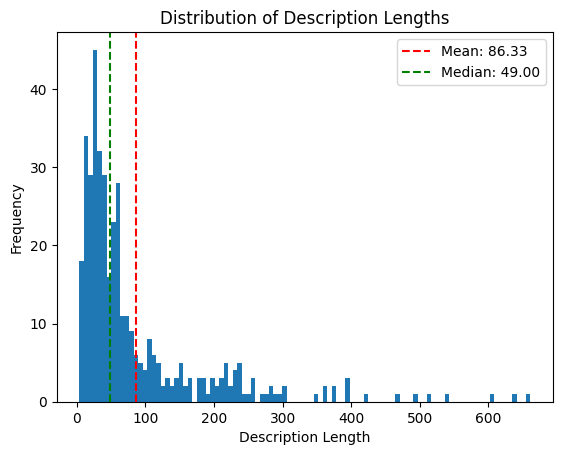

In [72]:
plt.hist(df["length"], bins=100)

mean = df["length"].mean()
median = df["length"].median()

plt.axvline(mean, color='red', linestyle='--')
plt.axvline(median, color='green', linestyle='--')

plt.xlabel("Description Length")
plt.ylabel("Frequency")
plt.title("Distribution of Description Lengths")

plt.legend([f"Mean: {mean:.2f}", f"Median: {median:.2f}"])

plt.show()

In [73]:
# display text with smallest length
df[df["length"] == df["length"].min()]["description"]


266    Datenschutzfolgeabschätzung zur elektronischen...
Name: description, dtype: object

In [74]:
# Convert the descriptions to a list
docs = df["description"].tolist()

# Initialize the SentenceTransformer model with the desired pre-trained model
embedding_model = SentenceTransformer('distiluse-base-multilingual-cased-v1')

# Calculate embeddings
embeddings = []

with tqdm(total=len(docs), ncols=80, desc="Calculating embeddings") as pbar:
    for doc in docs:
        embedding = embedding_model.encode([doc])[0]
        embeddings.append(embedding)
        pbar.update(1)

embeddings = np.stack(embeddings)

Calculating embeddings: 100%|█████████████████| 399/399 [00:53<00:00,  7.49it/s]


In [97]:


# prompt = "I have the following documents: [DOCUMENTS] \nThese documents are about the following topic: '"

# generator = pipeline('text2text-generation', model='google/flan-t5-base')
# representation_model = TextGeneration(generator)


german_stop_words = stopwords.words('german')
english_stop_words = stopwords.words('english')


# Define a custom preprocessor function
def custom_preprocessor(text):
    for word in text.split():
        if word == "fr":
            text = text.replace("fr", "für")
    text = " ".join([word for word in text.split() if word.lower() not in german_stop_words + ["bitte"] + english_stop_words])
    return text


# Create the CountVectorizer with the custom preprocessor
vectorizer = CountVectorizer(preprocessor=custom_preprocessor)

topic_model = BERTopic(vectorizer_model=vectorizer)

topics, probs = topic_model.fit_transform(docs, embeddings)

In [76]:
"für" in german_stop_words

True

In [98]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,114,-1_ber_Kosten_Abs_sowie,"[ber, Kosten, Abs, sowie, Informationen, bzw, ...",[Antrag nach dem IFG\r\n\r\nSehr geehrte Damen...
1,0,69,0_wurde_Verkehr_100_Informationen,"[wurde, Verkehr, 100, Informationen, ber, Bere...","[Hallo,\r\n\r\nDie DB Fernverkehr AG, dessen E..."
2,1,57,1_Abs_Antrag_IFG_NRW,"[Abs, Antrag, IFG, NRW, Informationen, betroff...",[Antrag nach dem IFG/UIG/VIG\r\n\r\nSehr geehr...
3,2,45,2_Daten_Dokumente_zB_internen,"[Daten, Dokumente, zB, internen, Umgang, Weisu...",[Sämtliche internen Dokumente zum Umgang mit R...
4,3,41,3_Urteil_Dokumenten_documents_Anfürage,"[Urteil, Dokumenten, documents, Anfürage, ange...","[Ich bitte um Übersendung des Gutachtens ""Rech..."
5,4,26,4_SARSCoV2_Infektion_Tests_Tage,"[SARSCoV2, Infektion, Tests, Tage, Anzahl, wur...",[Ich bitte im Zusammenhang der Corona Pandemie...
6,5,19,5_wievielen_viele_Fllen_Wieviele,"[wievielen, viele, Fllen, Wieviele, Prfung, je...",[Anzahl der suspendierten Polizisten mit Grund...
7,6,15,6_Mathematik_Fach_Abituraufgaben_Aufgaben,"[Mathematik, Fach, Abituraufgaben, Aufgaben, E...",[Sowohl die Übungsaufgaben für die Prüfungen s...
8,7,13,7_Einsparungen_Geschftsbetrieb_laufenden_Home,"[Einsparungen, Geschftsbetrieb, laufenden, Hom...",[Wie hoch waren die Einsparungen im laufenden ...


In [78]:
topic_model.get_document_info(docs)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,Antrag nach dem Informationsfreiheitsgesetz NR...,1,1_und_ich_nach_bitte,"[und, ich, nach, bitte, die, sie, abs, der, de...",[Antrag nach dem Informationsfreiheitsgesetz N...,und - ich - nach - bitte - die - sie - abs - d...,0.987637,True
1,Antrag nach dem IFG/UIG/VIG\r\n\r\nSehr geehrt...,1,1_und_ich_nach_bitte,"[und, ich, nach, bitte, die, sie, abs, der, de...",[Antrag nach dem Informationsfreiheitsgesetz N...,und - ich - nach - bitte - die - sie - abs - d...,0.818884,False
2,Standortbescheinigung aus EMF-Datenbank Nr. 88...,-1,-1_der_die_und_in,"[der, die, und, in, fr, sie, des, zu, von, ich]",[Antrag nach dem IFG/UIG/VIG\r\n\r\nSehr geehr...,der - die - und - in - fr - sie - des - zu - v...,0.000000,False
3,Ausgaben in Millionen für Bildung und Teilhabe...,1,1_und_ich_nach_bitte,"[und, ich, nach, bitte, die, sie, abs, der, de...",[Antrag nach dem Informationsfreiheitsgesetz N...,und - ich - nach - bitte - die - sie - abs - d...,0.837348,False
4,den Endbericht bzw. das Gutachten zum Projekt ...,-1,-1_der_die_und_in,"[der, die, und, in, fr, sie, des, zu, von, ich]",[Antrag nach dem IFG/UIG/VIG\r\n\r\nSehr geehr...,der - die - und - in - fr - sie - des - zu - v...,0.000000,False
...,...,...,...,...,...,...,...,...
394,Wie hoch waren die Einsparungen im laufenden G...,8,8_einsparungen_durch_geschftsbetrieb_laufenden,"[einsparungen, durch, geschftsbetrieb, laufend...",[Wie hoch waren die Einsparungen im laufenden ...,einsparungen - durch - geschftsbetrieb - laufe...,1.000000,True
395,"Bei der Sendung ""Wetten dass"" am 08.06.2013 wu...",-1,-1_der_die_und_in,"[der, die, und, in, fr, sie, des, zu, von, ich]",[Antrag nach dem IFG/UIG/VIG\r\n\r\nSehr geehr...,der - die - und - in - fr - sie - des - zu - v...,0.000000,False
396,1. Protokoll der Bohrlochbegehungen Düste14 un...,-1,-1_der_die_und_in,"[der, die, und, in, fr, sie, des, zu, von, ich]",[Antrag nach dem IFG/UIG/VIG\r\n\r\nSehr geehr...,der - die - und - in - fr - sie - des - zu - v...,0.000000,False
397,Für den Betrieb einer jeden offiziellen Dokume...,2,2_daten_der_und_oder,"[daten, der, und, oder, zum, dokumente, zb, di...",[Sämtliche internen Dokumente zum Umgang mit R...,daten - der - und - oder - zum - dokumente - z...,0.930024,False


In [79]:
df.iloc[0]

id                                                          9169
description    Antrag nach dem Informationsfreiheitsgesetz NR...
title                                Schließung diverser Schulen
length                                                       295
Name: 0, dtype: object

In [85]:
# make a list of objects with df id and df title
hover_lst = df[["id", "description"]]
# convert to list of concatenated columns
hover_lst = [f"{x[0]}: {x[1][:100]}" for x in hover_lst.values]


In [99]:
# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.visualize_documents(hover_lst, reduced_embeddings=reduced_embeddings)

In [82]:
hierarchical_topics = topic_model.hierarchical_topics(docs)

100%|██████████| 8/8 [00:00<00:00, 177.50it/s]


In [83]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)
